In [1]:
import sys
sys.path.append('../')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datasets.simulated.data_generators import LookupTableDataGenerator, SyntacticDataGenerator

# Lookup table

### Varying the sentence length

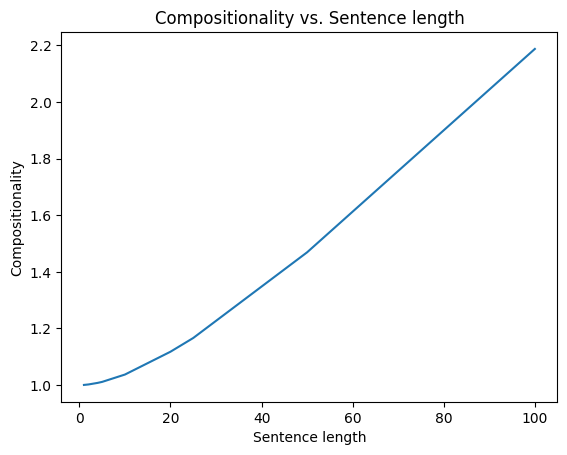

In [8]:
d = 100
compositionalities = []
ks = []
for k in range(1, d+1):
    if d % k != 0: # skip non-divisible k
        continue 
    data_gen = LookupTableDataGenerator(num_words=k, vocab_size=10, z_dim=d, disentanglement=1, noise_ratio=0.01)
    w, z = data_gen.sample(1000)
    compositionalities.append(data_gen.compositionality(z, w, per_sample=True))
    ks.append(k)

plt.title("Compositionality vs. Sentence length")
plt.xlabel("Sentence length")
plt.ylabel("Compositionality")
sns.lineplot(x=ks, y=compositionalities)
plt.show()

### Varying the dimensionality of the representation

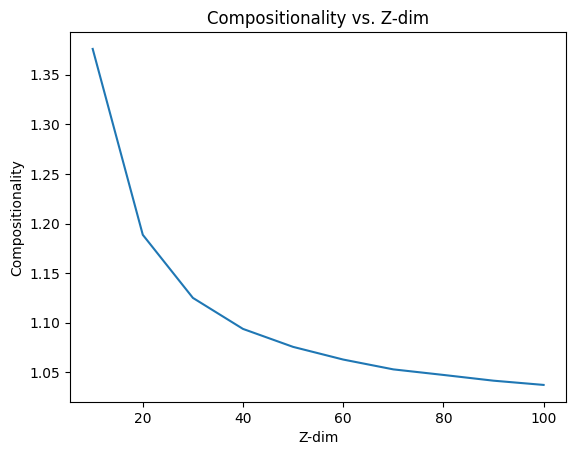

In [9]:
compositionalities = []
ds = []
k = 10
for d in range(k, k * 10 + 1):
    if d % k != 0: # skip non-divisible k
        continue 
    data_gen = LookupTableDataGenerator(num_words=k, vocab_size=10, z_dim=d, disentanglement=1, noise_ratio=0.01)
    w, z = data_gen.sample(1000)
    compositionalities.append(data_gen.compositionality(z, w, per_sample=True))
    ds.append(d)

plt.title("Compositionality vs. Z-dim")
plt.xlabel("Z-dim")
plt.ylabel("Compositionality")
sns.lineplot(x=ds, y=compositionalities)
plt.show()

## Varying the vocabulary size

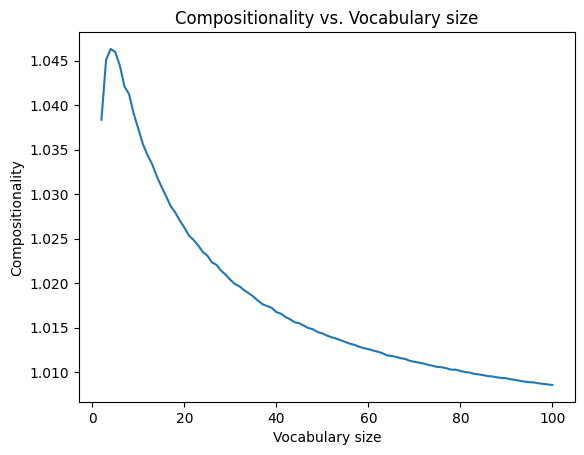

In [13]:
compositionalities = []
vs = []
vmax = 100
for v in range(2, vmax + 1):
    data_gen = LookupTableDataGenerator(num_words=10, vocab_size=v, z_dim=100, disentanglement=1, noise_ratio=0.01)
    w, z = data_gen.sample(1000)
    compositionalities.append(data_gen.compositionality(z, w, per_sample=True))
    vs.append(v)

plt.title("Compositionality vs. Vocabulary size")
plt.xlabel("Vocabulary size")
plt.ylabel("Compositionality")
sns.lineplot(x=vs, y=compositionalities)
plt.show()

### Varying the disentanglement

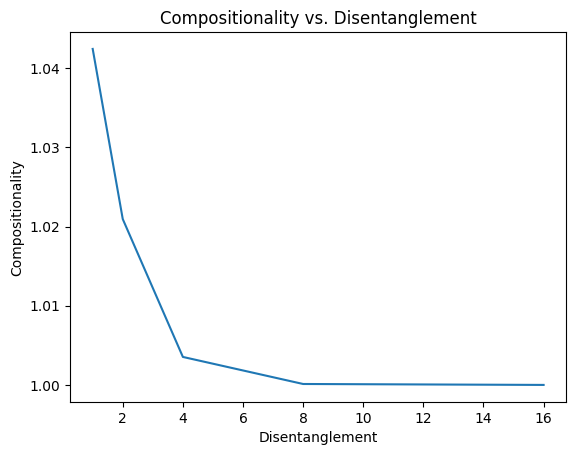

In [2]:
compositionalities = []
ds = []
k = 16
z_dim = k * 10
for d in range(1, k + 1):
    if k % d != 0:
        continue
    data_gen = LookupTableDataGenerator(num_words=k, vocab_size=2, z_dim=z_dim, disentanglement=d, noise_ratio=0.01)
    w, z = data_gen.sample(1000)
    compositionalities.append(data_gen.compositionality(z, w, per_sample=True))
    ds.append(d)

plt.title("Compositionality vs. Disentanglement")
plt.xlabel("Disentanglement")
plt.ylabel("Compositionality")
sns.lineplot(x=ds, y=compositionalities)
plt.show()

# Hierarchical syntax